In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [33]:
nft=pd.read_csv('nft.csv')

In [35]:
nft

,Date,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
0,2017-06-22,0.000000e+00,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-06-23,1.020300e+03,19,8.0,0,19.0,53.70,1.020300e+03,19.0,8.0,0.0
2,2017-06-24,2.261140e+03,40,21.0,0,21.0,56.53,1.240840e+03,21.0,13.0,0.0
3,2017-06-25,2.778690e+03,53,28.0,0,13.0,52.43,5.175500e+02,13.0,7.0,0.0
4,2017-06-26,3.203320e+03,67,34.0,0,14.0,47.81,4.246300e+02,14.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1601,2021-11-08,1.008803e+10,10913146,NaN,6541355,14829.0,924.39,7.706698e+07,59264.0,NaN,44435.0
1602,2021-11-09,1.014001e+10,10964025,NaN,6573511,18723.0,924.84,5.197508e+07,50879.0,NaN,32156.0
1603,2021-11-10,1.019902e+10,11008847,NaN,6601205,17128.0,926.44,5.901034e+07,44822.0,NaN,27694.0
1604,2021-11-11,1.023456e+10,11022782,NaN,6609013,6127.0,928.49,3.554317e+07,13935.0,NaN,7808.0


In [37]:
eth=pd.read_csv('coin_Ethereum.csv')

In [39]:
eth

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Ethereum,ETH,2015-08-08 23:59:59,2.798810,0.714725,2.793760,0.753325,6.741880e+05,4.548689e+07
1,2,Ethereum,ETH,2015-08-09 23:59:59,0.879810,0.629191,0.706136,0.701897,5.321700e+05,4.239957e+07
2,3,Ethereum,ETH,2015-08-10 23:59:59,0.729854,0.636546,0.713989,0.708448,4.052830e+05,4.281836e+07
3,4,Ethereum,ETH,2015-08-11 23:59:59,1.131410,0.663235,0.708087,1.067860,1.463100e+06,6.456929e+07
4,5,Ethereum,ETH,2015-08-12 23:59:59,1.289940,0.883608,1.058750,1.217440,2.150620e+06,7.364501e+07
...,...,...,...,...,...,...,...,...,...,...
2155,2156,Ethereum,ETH,2021-07-02 23:59:59,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11
2156,2157,Ethereum,ETH,2021-07-03 23:59:59,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11
2157,2158,Ethereum,ETH,2021-07-04 23:59:59,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11
2158,2159,Ethereum,ETH,2021-07-05 23:59:59,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11


In [41]:
nft_start_date=nft['Date'][0]
nft_end_date=nft['Date'][nft['Date'].count()-1]

In [43]:
print('nft start',nft_start_date,'nft end',nft_end_date)

nft start 2017-06-22 nft end 2021-11-12


In [45]:
eth_start_date=eth['Date'][0]
eth_end_date=eth['Date'][eth['Date'].count()-1]
print('eth start',eth_start_date,'eth end',eth_end_date)

eth start 2015-08-08 23:59:59 eth end 2021-07-06 23:59:59


In [47]:
eth=eth[eth['Date']>='2017-06-22 23:59:59']
nft=nft[nft['Date']<='2021-07-06']


In [ ]:
eth

In [16]:
eth['Date']=eth['Date'].str.extract('(.+)\s')

In [17]:
eth.index=np.arange(0,1476)

In [18]:
eth

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,685,Ethereum,ETH,2017-06-22,342.027008,330.622009,337.733002,336.371002,9.257670e+08,3.118533e+10
1,686,Ethereum,ETH,2017-06-23,348.006012,334.989990,336.484985,341.739014,5.932070e+08,3.169191e+10
2,687,Ethereum,ETH,2017-06-24,343.621002,322.087006,341.625000,323.696014,6.735850e+08,3.002724e+10
3,688,Ethereum,ETH,2017-06-25,332.791992,284.645996,323.466003,303.247986,1.186880e+09,2.813841e+10
4,689,Ethereum,ETH,2017-06-26,311.458008,238.649002,302.954987,272.691986,2.081810e+09,2.530976e+10
...,...,...,...,...,...,...,...,...,...,...
1471,2156,Ethereum,ETH,2021-07-02,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11
1472,2157,Ethereum,ETH,2021-07-03,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11
1473,2158,Ethereum,ETH,2021-07-04,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11
1474,2159,Ethereum,ETH,2021-07-05,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11


In [19]:
i=0
while(eth['Date'].iloc[i]==nft['Date'].iloc[i]):
    i+=1
print(i)
position_of_missing_value=i

932


In [20]:
print(eth['Date'].iloc[position_of_missing_value])
print(nft['Date'].iloc[position_of_missing_value])

2020-01-10
2020-01-09


In [21]:
print(eth['Date'].iloc[position_of_missing_value-1])
print(nft['Date'].iloc[position_of_missing_value-1])

2020-01-09
2020-01-09


In [22]:
print(eth['Date'].iloc[position_of_missing_value+1])
print(nft['Date'].iloc[position_of_missing_value+1])

2020-01-11
2020-01-10


In [23]:
nft=nft.drop(position_of_missing_value)

In [24]:
nft

,Date,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
0,2017-06-22,0.000000e+00,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-06-23,1.020300e+03,19,8.0,0,19.0,53.70,1020.30,19.0,8.0,0.0
2,2017-06-24,2.261140e+03,40,21.0,0,21.0,56.53,1240.84,21.0,13.0,0.0
3,2017-06-25,2.778690e+03,53,28.0,0,13.0,52.43,517.55,13.0,7.0,0.0
4,2017-06-26,3.203320e+03,67,34.0,0,14.0,47.81,424.63,14.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1472,2021-07-02,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
1473,2021-07-03,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
1474,2021-07-04,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0
1475,2021-07-05,1.481467e+09,6337518,353709.0,4069971,5357.0,233.76,5999974.94,9717.0,480.0,4360.0


In [25]:
nft.index=np.arange(0,1476)

In [26]:
nft

,Date,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
0,2017-06-22,0.000000e+00,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-06-23,1.020300e+03,19,8.0,0,19.0,53.70,1020.30,19.0,8.0,0.0
2,2017-06-24,2.261140e+03,40,21.0,0,21.0,56.53,1240.84,21.0,13.0,0.0
3,2017-06-25,2.778690e+03,53,28.0,0,13.0,52.43,517.55,13.0,7.0,0.0
4,2017-06-26,3.203320e+03,67,34.0,0,14.0,47.81,424.63,14.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1471,2021-07-02,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
1472,2021-07-03,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
1473,2021-07-04,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0
1474,2021-07-05,1.481467e+09,6337518,353709.0,4069971,5357.0,233.76,5999974.94,9717.0,480.0,4360.0


In [27]:
eth_nft=pd.merge(eth,nft)

In [28]:
eth_nft

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
0,685,Ethereum,ETH,2017-06-22,342.027008,330.622009,337.733002,336.371002,9.257670e+08,3.118533e+10,0.000000e+00,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,686,Ethereum,ETH,2017-06-23,348.006012,334.989990,336.484985,341.739014,5.932070e+08,3.169191e+10,1.020300e+03,19,8.0,0,19.0,53.70,1020.30,19.0,8.0,0.0
2,687,Ethereum,ETH,2017-06-24,343.621002,322.087006,341.625000,323.696014,6.735850e+08,3.002724e+10,2.261140e+03,40,21.0,0,21.0,56.53,1240.84,21.0,13.0,0.0
3,688,Ethereum,ETH,2017-06-25,332.791992,284.645996,323.466003,303.247986,1.186880e+09,2.813841e+10,2.778690e+03,53,28.0,0,13.0,52.43,517.55,13.0,7.0,0.0
4,689,Ethereum,ETH,2017-06-26,311.458008,238.649002,302.954987,272.691986,2.081810e+09,2.530976e+10,3.203320e+03,67,34.0,0,14.0,47.81,424.63,14.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,2156,Ethereum,ETH,2021-07-02,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
1472,2157,Ethereum,ETH,2021-07-03,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
1473,2158,Ethereum,ETH,2021-07-04,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0
1474,2159,Ethereum,ETH,2021-07-05,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11,1.481467e+09,6337518,353709.0,4069971,5357.0,233.76,5999974.94,9717.0,480.0,4360.0


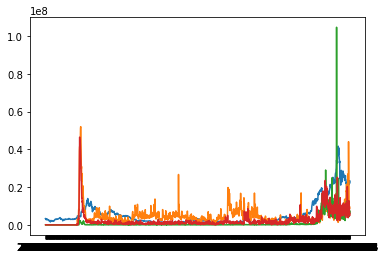

In [29]:
plt.plot(eth_nft['Date'],eth_nft['Close']*10000)
plt.plot(eth_nft['Date'],eth_nft['Number_of_Sales']*1000)
plt.plot(eth_nft['Date'],eth_nft['Sales_USD'])
plt.plot(eth_nft['Date'],eth_nft['Active_Market_Wallets']*10000)

In [32]:
parameters=['High','Low','Open','Close','Volume','Marketcap','Sales_USD_cumsum','Number_of_Sales_cumsum','Active_Market_Wallets_cumsum','Primary_Sales_cumsum','Secondary_Sales_cumsum','AverageUSD_cum','Sales_USD','Number_of_Sales','Active_Market_Wallets','Primary_Sales']

In [34]:
parameters.remove('Close')

In [36]:
eth_nft=eth_nft.dropna()
eth_nft

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
1,686,Ethereum,ETH,2017-06-23,348.006012,334.989990,336.484985,341.739014,5.932070e+08,3.169191e+10,1.020300e+03,19,8.0,0,19.0,53.70,1020.30,19.0,8.0,0.0
2,687,Ethereum,ETH,2017-06-24,343.621002,322.087006,341.625000,323.696014,6.735850e+08,3.002724e+10,2.261140e+03,40,21.0,0,21.0,56.53,1240.84,21.0,13.0,0.0
3,688,Ethereum,ETH,2017-06-25,332.791992,284.645996,323.466003,303.247986,1.186880e+09,2.813841e+10,2.778690e+03,53,28.0,0,13.0,52.43,517.55,13.0,7.0,0.0
4,689,Ethereum,ETH,2017-06-26,311.458008,238.649002,302.954987,272.691986,2.081810e+09,2.530976e+10,3.203320e+03,67,34.0,0,14.0,47.81,424.63,14.0,6.0,0.0
5,690,Ethereum,ETH,2017-06-27,293.088013,227.136993,272.691986,293.088013,1.973870e+09,2.721128e+10,5.296230e+03,100,44.0,0,33.0,52.96,2092.91,33.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,2156,Ethereum,ETH,2021-07-02,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
1472,2157,Ethereum,ETH,2021-07-03,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
1473,2158,Ethereum,ETH,2021-07-04,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0
1474,2159,Ethereum,ETH,2021-07-05,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11,1.481467e+09,6337518,353709.0,4069971,5357.0,233.76,5999974.94,9717.0,480.0,4360.0


In [38]:
train=eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*0.8)]
y_train=train['Close']
test=eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.8,eth_nft['Date'].count())]
y_test=test['Close']

In [40]:
test

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
1181,1866,Ethereum,ETH,2020-09-15,381.508293,363.606803,377.154029,364.839218,1.614058e+10,4.108764e+10,1.226192e+08,4875270,175767.0,3119480,790.0,25.15,478994.07,2957.0,109.0,2167.0
1182,1867,Ethereum,ETH,2020-09-16,372.767424,356.682746,364.743986,365.812291,1.610761e+10,4.120215e+10,1.228148e+08,4877917,176012.0,3121392,735.0,25.18,195585.79,2647.0,245.0,1912.0
1183,1868,Ethereum,ETH,2020-09-17,393.901600,364.795132,365.865770,389.019220,1.989953e+10,4.382135e+10,1.229943e+08,4879544,176154.0,3122767,252.0,25.21,179491.67,1627.0,142.0,1375.0
1184,1869,Ethereum,ETH,2020-09-18,391.904133,376.964987,389.337495,384.364542,1.410836e+10,4.330219e+10,1.234016e+08,4882740,176594.0,3125048,915.0,25.27,407321.15,3196.0,440.0,2281.0
1185,1870,Ethereum,ETH,2020-09-19,387.076345,378.724069,384.041667,385.544384,1.104951e+10,4.344036e+10,1.237001e+08,4884578,177160.0,3125962,924.0,25.32,298514.39,1838.0,566.0,914.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,2156,Ethereum,ETH,2021-07-02,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
1472,2157,Ethereum,ETH,2021-07-03,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
1473,2158,Ethereum,ETH,2021-07-04,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0
1474,2159,Ethereum,ETH,2021-07-05,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11,1.481467e+09,6337518,353709.0,4069971,5357.0,233.76,5999974.94,9717.0,480.0,4360.0


In [42]:
model=LinearRegression().fit(train[parameters],y_train)

In [44]:
y_pred = model.predict(train[parameters])
rss = sum((train['Close'] - y_pred)**2)

In [46]:
rss

28068.028853582757

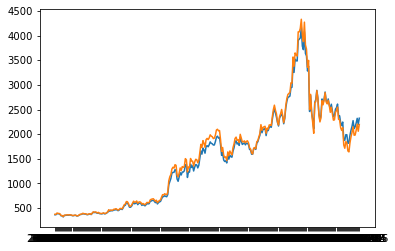

In [50]:
y_pred = model.predict(test[parameters])
rss = sum((y_test - y_pred)**2)
plt.plot(test['Date'],test['Close'])
plt.plot(test['Date'],y_pred)

In [34]:
rss

1779863.9036224508

In [35]:
train_score=model.score(train[parameters],y_train)

In [36]:
train_score

0.9995192543419086

In [37]:
test_score=model.score(test[parameters],y_test)

In [38]:
test_score

0.9932703611518744